In [1]:
import os
import random
import timm
import numpy as np
from scipy import interpolate
from PIL import Image
from tokenizers import Tokenizer
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

# Utils

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

Device used:  cuda


In [3]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s ' % checkpoint_path)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer = Tokenizer.from_file('./hw3_data/caption_tokenizer.json')

# Visualization

In [6]:
def imageshow(image, caption):
    """ show the image of a sample """
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xticks([])
    ax.set_yticks([])
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    # reshape the img from (3, 32, 32) to (32, 32, 3)
    plt.title(caption)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

# Custom Dataset & DataLoader

In [7]:
class HW3P2(Dataset):
    def __init__(self, dirpath, jsonpath, transforms):
        """ Initialize custom dataset """
        self.dirpath = dirpath
        self.coco = COCO(annotation_file=jsonpath)
        self.ids = list(sorted(self.coco.anns.keys()))
        self.transforms = transforms
    
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        ann_id = self.ids[index]
        img_id = self.coco.anns[ann_id]['image_id']
        caption = self.coco.anns[ann_id]['caption']
        path = self.dirpath + self.coco.loadImgs(img_id)[0]['file_name']

        # image
        image = Image.open(path).convert('RGB')
        if self.transforms is not None:
            image = self.transforms(image)

        return image, caption
    
    def __len__(self):
        """ Get total number of samples in the dataset """
        return len(self.ids)
        

In [8]:
trainset = HW3P2(
    dirpath='./hw3_data/p2_data/images/train/',
    jsonpath='./hw3_data/p2_data/train.json',
    transforms=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
)
valset = HW3P2(
    dirpath='./hw3_data/p2_data/images/val/',
    jsonpath='./hw3_data/p2_data/val.json',
    transforms=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [9]:
print("# of images in trainset: ", len(trainset))
print("# of images in valset: ", len(valset))

# of images in trainset:  53046
# of images in valset:  8946


In [10]:
dataloaders = {
    # 'train': DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4),
    'train': DataLoader(trainset, batch_size=64, shuffle=False, num_workers=4),
    'val': DataLoader(valset, batch_size=64, shuffle=False, num_workers=4),
}

In [11]:
dataiter = iter(dataloaders['train'])
images, captions = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)

Image tensor in each batch: torch.Size([64, 3, 224, 224]) torch.float32


In [12]:
print(len(captions))
tokens = tokenizer.encode_batch(captions)
print(len(tokens))
print(tokens[0].ids)
print(tokens[0].tokens)

64
64
[2, 115, 782, 3012, 887, 5030, 1792, 170, 115, 1153, 13, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['[BOS]', 'an', 'airplane', 'loading', 'or', 'unloading', 'passengers', 'at', 'an', 'airport', '.', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


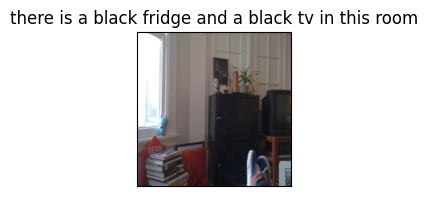

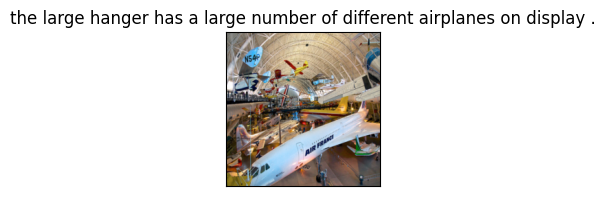

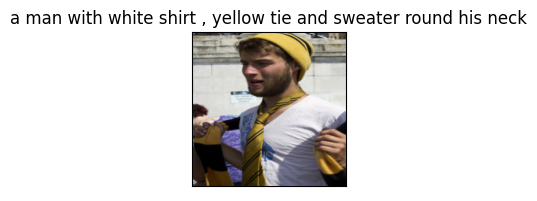

In [13]:
for i in range(3):
  image, caption = trainset[random.randint(0, len(trainset))]
  # image, caption = trainset[40354]
  token = torch.Tensor(tokenizer.encode(caption).ids).long()
  caption = [c for c in token.numpy()]
  caption = tokenizer.decode(caption)
  imageshow(image, caption)

# Model

In [14]:
# class Encoder101(nn.Module):
#     def __init__(self, encoded_image_size=14):
#         super(Encoder101, self).__init__()
#         self.enc_image_size = encoded_image_size

#         resnet = models.resnet101(pretrained=False)  # pretrained ImageNet ResNet-101

#         # Remove linear and pool layers (since we're not doing classification)
#         modules = list(resnet.children())[:-2]
#         self.resnet = nn.Sequential(*modules)

#         # Resize image to fixed size to allow input images of variable size
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

#         self.fine_tune()

#     def forward(self, images):
#         """
#         Forward propagation.
#         :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
#         :return: encoded images
#         """
#         out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
#         out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
#         out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
#         return out

#     def fine_tune(self, fine_tune=True):
#         """
#         Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
#         :param fine_tune: Allow?
#         """
#         for p in self.resnet.parameters():
#             p.requires_grad = False
#         # If fine-tuning, only fine-tune convolutional blocks 2 through 4
#         for c in list(self.resnet.children())[5:]:
#             for p in c.parameters():
#                 p.requires_grad = fine_tune

In [15]:
# encoder101 = Encoder101()
# print(images.shape)
# x = encoder101(images)
# print(x.shape)

In [16]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        # vit = timm.create_model('vit_large_patch16_224_in21k', pretrained=True)
        vit = timm.create_model('vit_huge_patch14_224_clip_laion2b', pretrained=True)
        modules = list(vit.children())[:]
        self.model = nn.Sequential(*modules)
        for param in self.model.parameters():
            param.requires_grad_(False)

    def forward(self, images):
        features = self.model(images)
        return features

In [17]:
encoder = Encoder()
# print(images.shape)
# x = encoder(images)
# print(x.shape)

In [18]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=1000, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size


        # Flatten image
        num_pixels = encoder_out.size(1)

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        # print(caption_lengths)
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas

In [19]:
# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
# dropout = 0.5
dropout = 0.1
vocab_size = 18021 + 1
decoder = DecoderWithAttention(attention_dim=attention_dim,
                                embed_dim=emb_dim,
                                decoder_dim=decoder_dim,
                                vocab_size=vocab_size,
                                encoder_dim=1024,
                                # encoder_dim=21843,
                                dropout=dropout)
encoder.to(device)
decoder.to(device)                                

DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=1024, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(18022, 512)
  (dropout): Dropout(p=0.1, inplace=False)
  (decode_step): LSTMCell(1536, 512)
  (init_h): Linear(in_features=1024, out_features=512, bias=True)
  (init_c): Linear(in_features=1024, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=1024, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=18022, bias=True)
)

In [20]:
# encoder_out = x.to(device)
# print('shape of encoder_out\t= {}'.format(encoder_out.shape))
# encoded_captions = []
# for i in range(len(tokens)):
#     encoded_captions.append(tokens[i].ids)
# encoded_captions = torch.Tensor(encoded_captions).long().to(device)
# print('shape of encoder_captions\t= {}'.format(encoded_captions.shape))
# caption_lengths = torch.Tensor([encoded_captions.shape[1]] * encoded_captions.shape[0]).long().to(device)
# print('shape of encoder_lengths\t= {}'.format(caption_lengths.shape))
# # print('encoder_lengths\t= {}'.format(caption_lengths))
# predictions, encoded_captions, decode_lengths, alphas = decoder(encoder_out, encoded_captions, caption_lengths)

In [21]:
# print(predictions.shape)
# print(encoded_captions.shape)
# print(decode_lengths)
# print(alphas.shape)

# Start Training

In [22]:
# decoder_lr = 4e-4  # learning rate for decoder
decoder_lr = 2e-5  # learning rate for decoder
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
grad_clip = 5.  # clip gradients at an absolute value of

In [23]:
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id('[PAD]')).to(device)

In [24]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)            

In [25]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    # encode_imgs = []
    # for batch_idx, (imgs, caps) in enumerate(train_loader):
    #     imgs = imgs.to(device)
    #     imgs = encoder(imgs)
    #     encode_imgs.append(imgs.cpu())
    
    # Batches
    for batch_idx, (imgs, caps) in enumerate(train_loader):

        # Move to GPU, if available
        imgs = imgs.to(device)

        tokens = tokenizer.encode_batch(caps)
        caps = []        
        for i in range(len(tokens)):
            caps.append(tokens[i].ids)
        caps = torch.Tensor(caps).long().to(device)

        caplens = torch.Tensor([caps.shape[1]] * caps.shape[0]).long().to(device)

        # Forward prop.
        imgs = encoder(imgs)
        # imgs = encode_imgs[batch_idx].to(device)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        # print(scores.shape)
        # print(targets.shape)

        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # print(scores.shape)
        # print(targets.shape)
        # break

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))


        # Print status
        if batch_idx % 200 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, batch_idx, len(train_loader),
                                                                          loss=losses,
                                                                          top5=top5accs))

In [26]:
save_dir = './checkpoint/transformer_large/'

In [27]:
load_checkpoint('./checkpoint/transformer_clip/decoder_epoch_016', decoder, decoder_optimizer)

model loaded from ./checkpoint/transformer_clip/decoder_epoch_016 


In [28]:
# init_epoch = 0
# for epoch in range(51):
#     train(
#         train_loader=dataloaders[ 'train'],
#         encoder=encoder,
#         decoder=decoder,
#         criterion=criterion,
#         encoder_optimizer=None,
#         decoder_optimizer=decoder_optimizer,
#         epoch=epoch,
#     )
#     save_checkpoint(save_dir + 'decoder_epoch_{:03d}'.format(epoch + init_epoch), decoder, decoder_optimizer)

# Inference

In [32]:
import clip
class CLIPScore:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        self.model.eval()

    def __call__(self, predictions, images_root):
        """
        Input:
            predictions: dict of str
            images_root: str
        Return:
            clip_score: float
        """
        total_score = 0.

        for img_name, pred_caption in predictions.items():
            image_path = os.path.join(images_root, f"{img_name}.jpg")
            image = Image.open(image_path).convert("RGB")

            total_score += self.getCLIPScore(image, pred_caption)
        return total_score / len(predictions)

    def getCLIPScore(self, image, caption):
        """
        This function computes CLIPScore based on the pseudocode in the slides.
        Input:
            image: PIL.Image
            caption: str
        Return:
            cilp_score: float
        """
        image_input = self.preprocess(image).unsqueeze(0).to(self.device)
        text_input = clip.tokenize([caption]).to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(image_input)
            text_features = self.model.encode_text(text_input)
        
        cos_sim = torch.nn.functional.cosine_similarity(image_features, text_features).item()
        return 2.5 * max(cos_sim, 0)

clip_score = CLIPScore()

# inference
def inference(encoder, decoder, image_path, beam_size=10):
    k = beam_size

    t = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    origin_image = Image.open(image_path).convert('RGB')
    image = t(origin_image).to(device) # [3, 224, 224]
    image = image.unsqueeze(0) # [1, 3, 224, 224]

    # encode
    encoder_out = encoder(image) # [1, 14x14 = 196, 1000]
    num_pixels = encoder_out.size(1)
    encoder_dim = encoder_out.size(2)
    
    # treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) # [k, 196, 1000]
    
    # tensor to stoe top k previous words at each step; now they are just **[BOS] = 2**
    k_prev_words = torch.LongTensor([[2]] * k).to(device) # [k, 1]

    # tensor to store top k sequences; now they are just [BOS]
    seqs = k_prev_words  # (k, 1)

    # tensor to store top k sequences' scores; now they are just 0s
    top_k_scores = torch.zeros(k, 1).to(device) # [k, 1]

    # tensor to store top k sequences' alphas; now they are just 1s
    seqs_alpha = torch.ones(k, 1, num_pixels).to(device) # [k, 1, 196]

    # lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # decode 
    step = 1
    h, c = decoder.init_hidden_state(encoder_out) # h: [k, embed_dim], c: [k, embed_dim]

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        # alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)
        
        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()], alpha[prev_word_inds.long()].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != 3 and next_word != 0] # **[EOS] = 3**
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds].long()]
        c = c[prev_word_inds[incomplete_inds].long()]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            complete_seqs.extend(seqs[incomplete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[incomplete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[incomplete_inds])
            break
        step += 1
        # print(seqs)

    max_score = -1
    final_ans_i = 0
    for i in range(k):
        score = clip_score.getCLIPScore(origin_image,  tokenizer.decode(complete_seqs[i]))
        if score > max_score:
            max_score = score
            final_ans_i = i

    # i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[final_ans_i]
    alphas = complete_seqs_alpha[final_ans_i]

    return seq, alphas, complete_seqs, complete_seqs_alpha

In [33]:
# for i in range(0, 201, 5):
#     load_checkpoint('./checkpoint/transformer_transformer/decoder_epoch_{:03d}'.format(i), decoder, decoder_optimizer)
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/bike.jpg')
print(tokenizer.decode(seq))
for i in range(len(complete_seqs)):
    print(tokenizer.decode(complete_seqs[i]))
print('-----')
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/girl.jpg')
print(tokenizer.decode(seq))
for i in range(len(complete_seqs)):
    print(tokenizer.decode(complete_seqs[i]))
print('-----')
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/sheep.jpg')
print(tokenizer.decode(seq))
for i in range(len(complete_seqs)):
    print(tokenizer.decode(complete_seqs[i]))
print('-----')
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/ski.jpg')
print(tokenizer.decode(seq))
for i in range(len(complete_seqs)):
    print(tokenizer.decode(complete_seqs[i]))
print('-----')
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/umbrella.jpg')
print(tokenizer.decode(seq))
for i in range(len(complete_seqs)):
    print(tokenizer.decode(complete_seqs[i]))
print('-----')

a row of bicycles parked next to a building
a row of bicycles parked next to a building
a couple of bicycles parked next to a building
a row of bicycles parked next to a building .
a couple of bikes are parked next to each other
a couple of bikes are parked next to a building
a couple of bikes that are parked next to each other
a couple of bicycles that are parked next to each other
a couple of bikes are parked next to each other .
a couple of bikes are parked next to a building .
a couple of bikes that are parked next to each other .
-----
a woman in a pink shirt eats a sandwich .
a woman in a pink shirt eats a sandwich .
a woman in a pink shirt holds a baby .
a woman in a pink shirt is holding a baby .
a little girl in a pink shirt eats a sandwich .
a woman in a pink shirt eats a slice of pizza .
a little girl in a pink shirt is holding a baby .
a woman in a pink shirt is holding a baby in his mouth .
a woman in a pink shirt eats a sandwich with a little girl .
a woman in a pink shir

In [34]:

# import skimage.transform
def visualize_att(image_path, seq, alphas, words, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    upscale = 16

    image = Image.open(image_path)
    image = image.resize([16 * upscale, 16 * upscale])

    words = words.split()
    words.insert(0, '[BOS]')
    nrows = int(np.ceil(len(words) / 5.))
    ncols = 5
    for t in range(len(words)):
        plt.subplot(nrows, ncols, t + 1)        
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = np.array(alphas[t + 1]).reshape(16, 16)
        # current_alpha = alphas[t]
        alpha = current_alpha.repeat(upscale, axis = 0).repeat(upscale, axis = 1)

        # print(alpha)
        # alpha = skimage.transform.pyramid_expand(np.array(current_alpha), upscale=upscale, sigma=8)
        # alpha = skimage.transform.resize(np.array(current_alpha), [14 * upscale, 14 * upscale])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

a person riding a bike down a street .
256


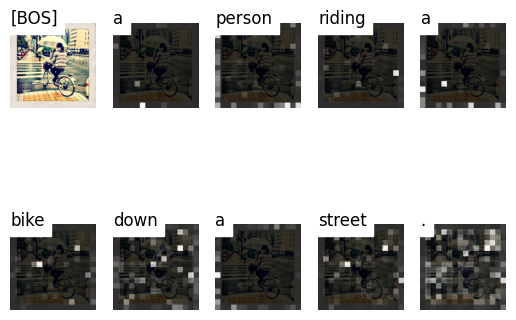

In [35]:
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/bike.jpg')
print(tokenizer.decode(seq))
print(len(alphas[0]))
visualize_att('./hw3_data/p3_data/images/bike.jpg', seq, alphas, tokenizer.decode(seq))

a woman in a pink shirt is holding a baby
256


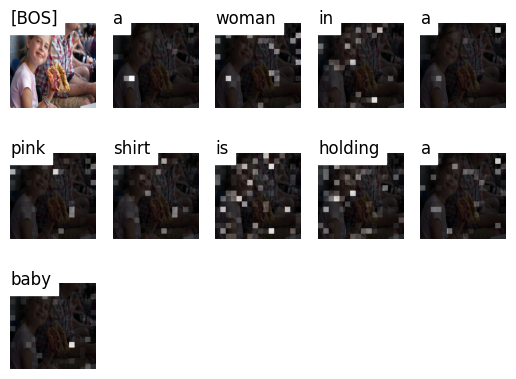

In [36]:
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/girl.jpg')
print(tokenizer.decode(seq))
print(len(alphas[0]))
visualize_att('./hw3_data/p3_data/images/girl.jpg', seq, alphas, tokenizer.decode(seq))

a herd of sheep standing in a field
256


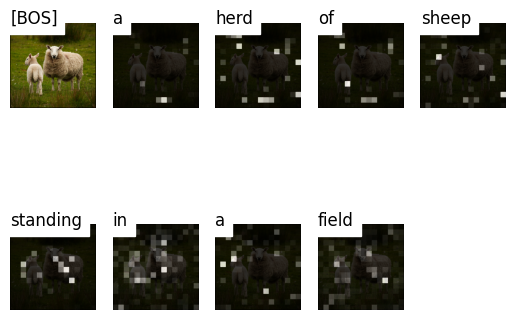

In [37]:
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/sheep.jpg')
print(tokenizer.decode(seq))
print(len(alphas[0]))
visualize_att('./hw3_data/p3_data/images/sheep.jpg', seq, alphas, tokenizer.decode(seq))

a person riding skis on a snowy slope
256


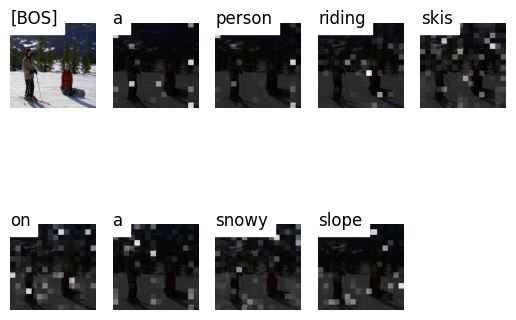

In [38]:
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/ski.jpg')
print(tokenizer.decode(seq))
print(len(alphas[0]))
visualize_att('./hw3_data/p3_data/images/ski.jpg', seq, alphas, tokenizer.decode(seq))

a black and white photo of a man and woman
256


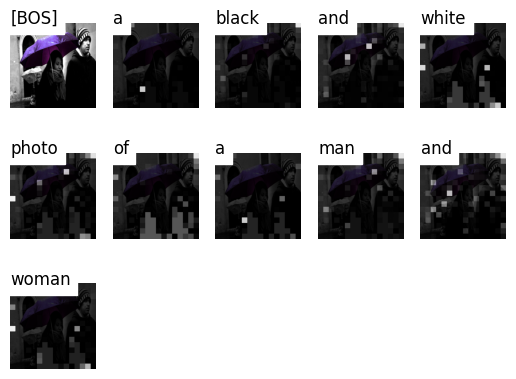

In [39]:
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p3_data/images/umbrella.jpg')
print(tokenizer.decode(seq))
print(len(alphas[0]))
visualize_att('./hw3_data/p3_data/images/umbrella.jpg', seq, alphas, tokenizer.decode(seq))

a man in a blue shirt and blue jeans stands in front of a microphone .
256


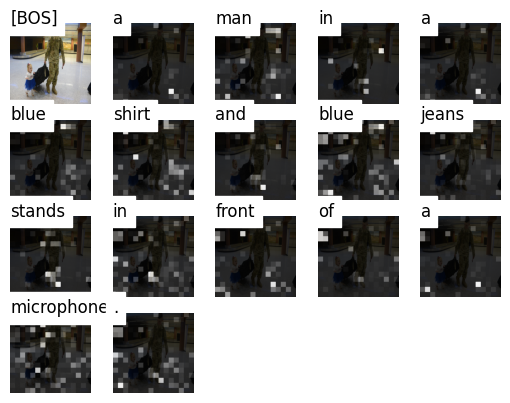

In [40]:
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p2_data/images/val/000000056306.jpg')
print(tokenizer.decode(seq))
print(len(alphas[0]))
visualize_att('./hw3_data/p2_data/images/val/000000056306.jpg', seq, alphas, tokenizer.decode(seq))

a yellow bus driving down the road .
256


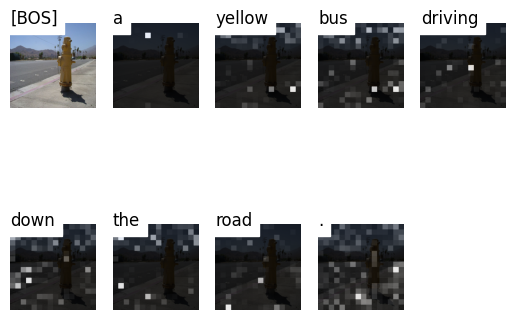

In [41]:
seq, alphas, complete_seqs, complete_seqs_alpha = inference(encoder, decoder, './hw3_data/p2_data/images/val/000000392315.jpg')
print(tokenizer.decode(seq))
print(len(alphas[0]))
visualize_att('./hw3_data/p2_data/images/val/000000392315.jpg', seq, alphas, tokenizer.decode(seq))